In [ ]:
# !git clone https://github.com/JLNeuroLab/SINDy-autoencoder.git
# %cd SINDy-autoencoder


Cloning into 'SINDy-autoencoder'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 28 (delta 3), reused 28 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (28/28), 482.00 KiB | 12.05 MiB/s, done.
Resolving deltas: 100% (3/3), done.
/content/SINDy-autoencoder


In [2]:
import os
import sys
from pathlib import Path

# path che vuoi usare come root
ROOT = Path("/content/SINDy-autoencoder")

os.chdir(ROOT)       # cambia la working directory
sys.path.append(str(ROOT))   # così puoi importare model.py, trainer.py, ecc.

print("Current working directory:", os.getcwd())

Current working directory: /content/SINDy-autoencoder


In [3]:
import numpy as np
import pandas as pd
import json

datadir = Path("dataset_2022_silverstone_ham")

X = np.load(datadir/"X.npy")
t = np.load(datadir/"t.npy")
lap_idx = np.load(datadir/"lap_indices.npy")

with open(datadir/"metadata.json") as f:
    meta = json.load(f)

state_cols = meta["state_cols"]
dt = meta["dt"]

scaler = json.load(open(datadir / "scaler.json"))

X_mean = np.array(scaler["X_mean"])
X_scale = np.array(scaler["X_scale"])

X_phys = X * X_scale + X_mean
df_phys = pd.DataFrame(X_phys, columns=state_cols)
df_phys["t"] = t
df_phys["lap"] = lap_idx

df_phys.to_csv(datadir / "dataset_physical_units.csv", index=False)
print(df_phys.head())
print(df_phys.info())
print(X_phys.shape)
print(t.shape)
print(lap_idx.shape)

   Distance       Speed  Throttle  Brake     nGear           RPM            X  \
0  0.000000  252.524998     100.0    0.0  6.000000  10635.925357 -1771.696849   
1  1.405556  252.774999     100.0    0.0  6.000000  10580.175169 -1763.191162   
2  2.813889  253.062112     100.0    0.0  6.012422  10533.118012 -1754.669267   
3  4.247222  253.683230     100.0    0.0  6.136646  10564.298137 -1746.001490   
4  5.680556  254.304348     100.0    0.0  6.260870  10595.478261 -1737.333713   

             Y            Z     t  lap  
0  1189.633010  1963.202931  0.00    0  
1  1201.007901  1963.261456  0.02    0  
2  1212.381744  1963.322393  0.04    0  
3  1223.746160  1963.405044  0.06    0  
4  1235.110575  1963.487695  0.08    0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4526 entries, 0 to 4525
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Distance  4526 non-null   float64
 1   Speed     4526 non-null   float64
 2  

In [4]:
# F1_SINDyAE Notebook - Setup

import numpy as np
import pandas as pd
import json
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from src.model import SINDy_Autoencoder, TimeSeriesDataset   # your model classes
from src.trainer import Trainer_SINDyAE                      # your trainer
from utils.diff_methods import compute_derivatives             # your derivative util

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)



Using device: cuda


In [5]:
# Build fixed-length time windows from the long time series
# Result: X_seq with shape (n_traj, T_window, n_state)

T_window = 200   # sequence length (es. 200 step)
stride = 20      # shift from one window to the following one

N, x_dim = X.shape
print("N samples:", N, "| x_dim:", x_dim)

windows = []
for start in range(0, N - T_window + 1, stride):
    end = start + T_window
    windows.append(X[start:end, :])

X_seq = np.stack(windows, axis=0)   # (n_traj, T_window, x_dim)
print("X_seq shape:", X_seq.shape)

N samples: 4526 | x_dim: 9
X_seq shape: (217, 200, 9)


In [ ]:
# Model hyperparameters

x_dim = X_seq.shape[-1]   # number of state variables (Distance, Speed, Throttle, ...)
z_dim = 3               # es: 3 latent dimensions (you choose)

enc_hidden = (128, 64)    # encoder MLP sizes
dec_hidden = (64, 128)    # decoder MLP sizes
poly_order = 3            # polynomial library for SINDy
include_bias = True

model = SINDy_Autoencoder(
    x_dim=x_dim,
    z_dim=z_dim,
    enc_hidden=enc_hidden,
    dec_hidden=dec_hidden,
    poly_order=poly_order,
    include_bias=include_bias,
).to(device)

print(model)

SINDy_Autoencoder(
  (autoencoder): Autoencoder(
    (encoder): Encoder(
      (net): Sequential(
        (0): Linear(in_features=9, out_features=128, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=128, out_features=64, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=64, out_features=3, bias=True)
      )
    )
    (decoder): Decoder(
      (net): Sequential(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): Sigmoid()
        (2): Linear(in_features=64, out_features=128, bias=True)
        (3): Sigmoid()
        (4): Linear(in_features=128, out_features=9, bias=True)
      )
    )
  )
  (sindy): SINDy_layer()
)


In [68]:
# Trainer hyperparameters

trainer = Trainer_SINDyAE(
    model=model,
    dt=dt,
    diff_method="finite-diff",      # o il tuo metodo (dipende da diff_methods.py)
    diff_kwargs={},

    batch_size=32,
    shuffle=True,
    device=device,

    lambda_recon=1.0,
    lambda_dx=1.0,
    lambda_dz=0.1,

    threshold=0.1,
    threshold_freq=50,
    lr=1e-3,
)

print("Trainer ready.")

[INIT] Using device: cuda
[INIT] Model first param device: cuda:0
Trainer ready.


In [ ]:
# Train the model on the F1 sequences

n_epochs = 1000
log_every = 50

trainer.fit(
    X_seq,
    n_epochs=n_epochs,
    warmup_epochs=5,
    log_every=log_every,
)

[TRAIN] Epoch     1/1000 | Loss: 2.3447e+00 | Lrecon: 8.5603e-02 | Ldx: 2.2515e+00 | Ldz: 7.5677e-02 | 
[TRAIN] Epoch    50/1000 | Loss: 1.6289e+00 | Lrecon: 9.5703e-02 | Ldx: 1.5163e+00 | Ldz: 1.6839e-01 | 
[TRAIN] Epoch   100/1000 | Loss: 1.5319e+00 | Lrecon: 8.8135e-02 | Ldx: 1.4218e+00 | Ldz: 2.1963e-01 | 
[TRAIN] Epoch   150/1000 | Loss: 1.4207e+00 | Lrecon: 8.0148e-02 | Ldx: 1.3157e+00 | Ldz: 2.4903e-01 | 
[TRAIN] Epoch   200/1000 | Loss: 1.3348e+00 | Lrecon: 7.1300e-02 | Ldx: 1.2353e+00 | Ldz: 2.8268e-01 | 
[TRAIN] Epoch   250/1000 | Loss: 1.3177e+00 | Lrecon: 6.7306e-02 | Ldx: 1.2204e+00 | Ldz: 2.9996e-01 | 
[TRAIN] Epoch   300/1000 | Loss: 1.2103e+00 | Lrecon: 6.1426e-02 | Ldx: 1.1164e+00 | Ldz: 3.2491e-01 | 
[TRAIN] Epoch   350/1000 | Loss: 1.1930e+00 | Lrecon: 6.0181e-02 | Ldx: 1.0998e+00 | Ldz: 3.2975e-01 | 
[TRAIN] Epoch   400/1000 | Loss: 1.2577e+00 | Lrecon: 5.9089e-02 | Ldx: 1.1634e+00 | Ldz: 3.5257e-01 | 
[TRAIN] Epoch   450/1000 | Loss: 1.1949e+00 | Lrecon: 5.4825e-02

,loss,L_recon,L_dx,L_dz
995,0.994911,0.043245,0.916278,0.353885
996,0.965368,0.043124,0.887364,0.348802
997,0.966531,0.042497,0.888525,0.355093
998,0.956490,0.042099,0.879277,0.351138
999,0.941747,0.042110,0.864452,0.351851


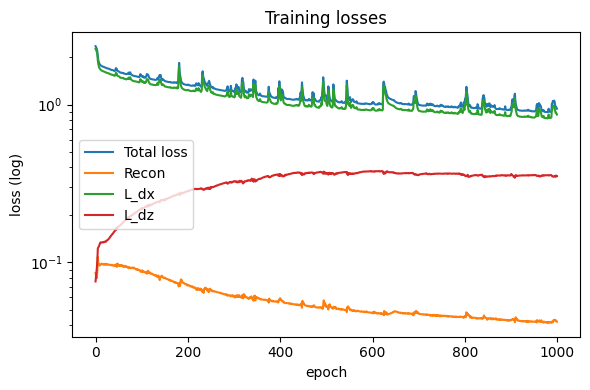

In [70]:
# Inspect training history

hist = pd.DataFrame(trainer.history_loss)
display(hist.tail())

plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="Total loss")
plt.plot(hist["L_recon"], label="Recon")
plt.plot(hist["L_dx"], label="L_dx")
plt.plot(hist["L_dz"], label="L_dz")
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("loss (log)")
plt.legend()
plt.title("Training losses")
plt.tight_layout()
plt.show()

In [71]:
# Take one sequence and run it through the trained model

from utils.diff_methods import compute_derivatives

model.eval()

# pick one trajectory
x_seq_np = X_seq[0:1]  # shape (1, T_window, x_dim)

# compute derivatives for that trajectory (same method as trainer)
xdot_np = compute_derivatives(x_seq_np, dt, diff_method="finite-diff")

x_seq_t = torch.from_numpy(x_seq_np).float().to(device)
xdot_t = torch.from_numpy(xdot_np).float().to(device)

with torch.no_grad():
    x_hat_seq, z_seq, losses = model(
        x_seq_t,
        xdot_t,
        lambda_recon=1.0,
        lambda_dx=1.0,
        lambda_dz=1.0,
    )

print("Reconstruction loss on this sequence:", losses["L_recon"].item())
print("z_seq shape:", z_seq.shape)

x_seq_np_rec = x_hat_seq.cpu().numpy()[0]   # (T_window, x_dim)
z_seq_np = z_seq.detach().cpu().numpy()[0]          # (T_window, z_dim)


Reconstruction loss on this sequence: 0.047602329403162
z_seq shape: torch.Size([1, 200, 3])


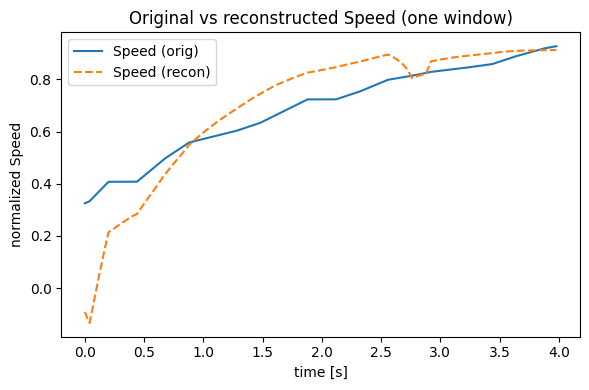

In [72]:
# Compare original vs reconstructed for Speed

cols = state_cols
if "Speed" in cols:
    speed_idx = cols.index("Speed")
else:
    speed_idx = 1  # fallback

time_local = np.arange(x_seq_np.shape[1]) * dt

plt.figure(figsize=(6,4))
plt.plot(time_local, x_seq_np[0, :, speed_idx], label="Speed (orig)")
plt.plot(time_local, x_seq_np_rec[:, speed_idx], "--", label="Speed (recon)")
plt.xlabel("time [s]")
plt.ylabel("normalized Speed")
plt.legend()
plt.title("Original vs reconstructed Speed (one window)")
plt.tight_layout()
plt.show()


In [74]:
# Inspect SINDy coefficient matrix Xi

Xi = model.sindy.Xi.detach().cpu().numpy()
Xi_mask = model.sindy.Xi_mask.detach().cpu().numpy()

print("Xi shape (n_terms, z_dim):", Xi.shape)

# Mostra i coefficienti non nulli per ogni dimensione latente
for j in range(Xi.shape[1]):
    nonzero = np.where(np.abs(Xi[:, j]) > 1e-6)[0]
    print(f"\nLatent dim z_{j}: {len(nonzero)} active terms")
    print(Xi[nonzero, j])


Xi shape (n_terms, z_dim): (20, 3)

Latent dim z_0: 6 active terms
[ 0.5085993  -0.9185277  -0.6448519   0.37659258  0.65488404  0.30566484]

Latent dim z_1: 2 active terms
[-0.3183087   0.42179427]

Latent dim z_2: 8 active terms
[ 0.7752624   1.7450554   0.33079916 -0.20295577 -0.58350027 -0.26461068
 -0.8093648  -0.28390527]


In [75]:
# === Salvataggio pesi modello SINDy Autoencoder ===

import torch
import os

# Nome file (puoi cambiarlo)
save_path = "sindyae_trained.pt"

# Salva i pesi
torch.save(model.state_dict(), save_path)

print(f"Modello salvato correttamente in: {save_path}")


Modello salvato correttamente in: sindyae_trained.pt


In [1]:
import torch

# === Salvataggio checkpoint completo SINDy-AE ===

save_path = "sindyae_full_checkpoint.pt"

checkpoint = {
    "state_dict": model.state_dict(),
    "hyperparams": {
        "x_dim": model.x_dim,
        "z_dim": model.z_dim,
        # QUI metti i valori che hai usato quando hai creato il modello
        "enc_hidden": (128, 64),   # <-- cambia se diverso
        "dec_hidden": (64, 128),   # <-- cambia se diverso
        "poly_order": 3,           # <-- cambia se diverso
        "include_bias": True,      # <-- cambia se diverso
    }
}

torch.save(checkpoint, save_path)
print(f"Checkpoint salvato in: {save_path}")


NameError: name 'model' is not defined